# NDCube Testing
Can we combine NDCube with Dask to create a lazily evaluated data cube for analyzing AIA data?

In [1]:
import copy
import glob

import astropy.units as u
import astropy.time
import astropy.wcs
import drms
from sunpy.map import Map
from sunpy.io.fits import get_header
from sunpy.util.metadata import MetaDict
import matplotlib.pyplot as plt
import numpy as np
from ndcube import NDCube
import dkist.dataset
from dkist.data.sample import EIT_DATASET
import intake
import dask.array as da
from dask.array.utils import meta_from_array

%matplotlib inline

Get a modest amount of data from a single channel for testing purposes

First, get the time information

In [2]:
t = astropy.time.Time(
    [get_header(f)[0]['DATE-OBS'] for f in sorted(glob.glob('test_data/*.fits'))])
t = (t - t[0]).to(u.s)

Load all data into a Dask array with `intake`

In [3]:
source = intake.open_fits_array('test_data/*.fits',ext=0)

In [4]:
darr = source.to_dask()

In [5]:
darr.shape

(49, 500, 500)

And load the WCS for the whole stack

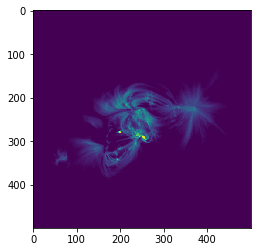

In [17]:
plt.imshow(np.flipud(darr[0,:,:]),vmin=1e3,vmax=5e3)

In [31]:
source.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  500                                                  
NAXIS2  =                  500                                                  
BLD_VERS= 'V5R12X  '                                                            
LVL_NUM =                  1.5                                                  
T_REC   = '2011-02-12T12:00:13Z'                                                
TRECSTEP=                  1.0                                                  
TRECEPOC= '1977.01.01_00:00:00_TAI'                                             
TRECROUN=                    1                                                  
ORIGIN  = 'SDO/JSOC-SDP'                                                        
DATE    = '2011-02-16T09:35:

In [6]:
wcs_header = source.wcs.to_header()

In [7]:
wcs_header

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                733.5 / Pixel coordinate of reference point            
CRPIX2  =                625.5 / Pixel coordinate of reference point            
PC1_1   =                  1.0 / Coordinate transformation matrix element       
PC1_2   =  -2.168404344971E-19 / Coordinate transformation matrix element       
PC2_2   =                  1.0 / Coordinate transformation matrix element       
CDELT1  =  0.00016666666666667 / [deg] Coordinate increment at reference point  
CDELT2  =  0.00016666666666667 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'HPLN-TAN'           / Coordinate type codegnomonic projection        
CTYPE2  = 'HPLT-TAN'           / Coordinate type codegnomonic projection        
CRVAL1  =                  0

Construct WCS from spatial wcs plus the time axis

In [18]:
# Load a map and pull meta from there instead
m = Map('test_data/aia_lev1.5_20110212T120012_171_cutout.fits')

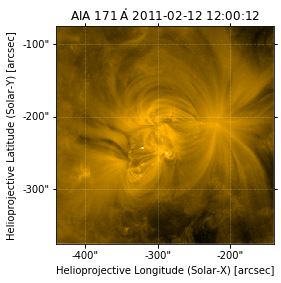

In [19]:
m.plot()

In [22]:
m.plot_settings

{'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x115730c18>,
 'norm': <astropy.visualization.mpl_normalize.ImageNormalize at 0xd18ad0a58>,
 'interpolation': 'nearest',
 'origin': 'lower'}

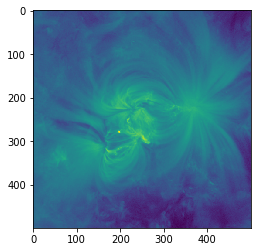

In [25]:
plt.imshow(np.flipud(darr[-1,:,:]),norm=m.plot_settings['norm'])

In [8]:
wcs_input_dict = {
    # Time
    'CTYPE3': 'TIME', 'CUNIT3': 's', 'CDELT3': np.diff(t).to(u.s).value[0], 'CRPIX3': 0, 'CRVAL3': 0, 'NAXIS3': t.shape[0],
    # LAT
    'CTYPE2': wcs_header['CTYPE2'], 'CUNIT2': wcs_header['CUNIT2'], 'CRPIX2': wcs_header['CRPIX2'], 'CRVAL2': wcs_header['CRVAL2'], 'NAXIS2': darr.shape[1],
    # LON
    'CTYPE1': wcs_header['CTYPE1'], 'CUNIT1': wcs_header['CUNIT1'], 'CRPIX1': wcs_header['CRPIX1'], 'CRVAL1': wcs_header['CRVAL1'], 'NAXIS1': darr.shape[2],

}

Create the NDCube object

In [9]:
aiacube = NDCube(darr, astropy.wcs.WCS(wcs_input_dict))

In [10]:
aiacube.data

dask.array<fits-array, shape=(49, 500, 500), dtype=float64, chunksize=(1, 500, 500)>

In [12]:
aiacube.axis_world_coords('time').shape

(49,)

In [13]:
aiacube.dimensions

<Quantity [ 49., 500., 500.] pix>

In [14]:
aiacube.world_axis_physical_types

('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

In [15]:
aiacube.dimensions

<Quantity [ 49., 500., 500.] pix>

In [16]:
aiacube.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 733.5  625.5  0.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 1.0  1.0  12.00000000000188  
NAXIS : 500  500  49

In [37]:
aiacube[:,200:300,200:300].wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'TIME'  'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.0  0.0  0.0  
CRPIX : -200.0  533.5  625.5  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 12.00000000000188  0.00016666666666666666  0.00016666666666666666  
NAXIS : 0  0  500

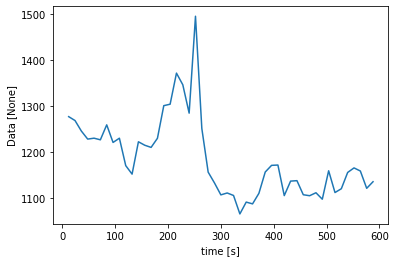

In [34]:
aiacube[:,200,200].plot()

In [35]:
aiacube.data

dask.array<fits-array, shape=(49, 500, 500), dtype=float64, chunksize=(1, 500, 500)>

In [39]:
foo = aiacube.data.rechunk((aiacube.data.shape[:1] + (aiacube.data.shape[1]//10, aiacube.data.shape[2]//10)))

In [43]:
foo

dask.array<rechunk-merge, shape=(49, 500, 500), dtype=float64, chunksize=(49, 50, 50)>

In [41]:
foobar = foo[::-1,:,:]

In [42]:
foobar

dask.array<getitem, shape=(49, 500, 500), dtype=float64, chunksize=(49, 50, 50)>

In [47]:
foobar.std(axis=0)

dask.array<sqrt, shape=(500, 500), dtype=float64, chunksize=(50, 50)>